# **E-1. 가위바위보 분류기**

-----

딥러닝 모델을 이용한 간단한 이미지 분류기 만들기

- TensorFlow 표준 API인 Keras의 Sequential 분류 모델 활용

- 이미지 데이터 준비 및 전처리 실습

- train, test 데이터셋 분리 및 활용

- 다양한 지표를 통해 모델 성능 확인 및 개선

## **목차**


1. 데이터 수집 및 전처리
2. 모델 설계 및 학습
3. 성능 평가 및 개선

In [276]:
# 필요한 모듈 import
import glob
import os
import random

import numpy as np
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

## **1. 데이터 수집 및 전처리**

### 1-1. 데이터 수집

- Teachable Machine을 활용해 가위, 바위, 보 손 모양 직접 촬영
- 다른 교육생들과 [데이터 취합](https://drive.google.com/drive/u/0/folders/1-IixArXNZVn1Z72zAxA-MnKl4uOHn0st)
- 그 중 1200장의 이미지 데이터를 train, validation 데이터셋으로 활용
- test 데이터셋은 300장을 추가로 확보하여 활용

### 1-2. train 데이터 정제

- 배경과 대상 object가 비교적 잘 구분되는 이미지를 선별
- 지나치게 복잡한 배경(패턴, 색깔 등)의 이미지는 삭제 후 다른 이미지로 대체

**예시 1) 배경이 복잡한 경우 -> 삭제 후 다른 이미지로 대체**
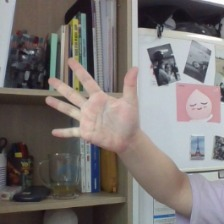 

**예시 2) 평면에서 구분이 안 되는 경우 -> 삭제 후 다른 이미지로 대체**
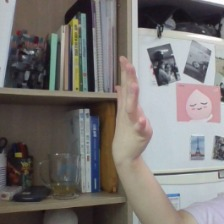

**예시 3) 배경이 단순하고 대상 object가 선명한 이미지 위주로 선별**

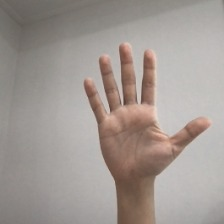

### 1-3. 데이터 다양성 확보
- train 데이터셋의 이미지들을 회전, shift시켜서 다양성 확보

#### 예시) train 데이터셋 중 랜덤하게 이미지를 선택해 회전시킴

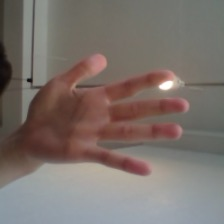

### 1-4. 이미지 크기 변경

- random으로 원본 이미지를 불러와서 크기 확인
- 224x224 크기의 원본 이미지를 112x112으로 변경해서 저장

(가로, 세로) = (224, 224)


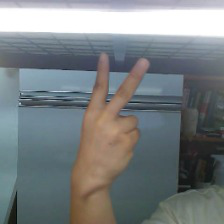

In [270]:
# 이미지(데이터)가 저장된 디렉터리 경로를 변수에 저장
image_dir_path = os.getenv("HOME") + "/aiffel/aiffel_projects/rock_scissor_paper"


# random으로 이미지를 불러와서 원본 크기 확인
images = glob.glob(image_dir_path + "/scissor" + "/*.jpg")

# images = glob.glob(image_dir_path + "/paper" + "/*.jpg")
# images = glob.glob(image_dir_path + "/rock" + "/*.jpg")

rand_idx = random.randint(1, len(images))
img = Image.open(images[rand_idx])

print(f"(가로, 세로) = ({img.width}, {img.height})")
img

In [277]:
# 이미지 크기를 112x112으로 변경 후 저장
def resize_images(img_path):
    images = glob.glob(img_path + "/*.jpg")
    
    print(len(images), " images to be resized.")          # 변경이 필요한 이미지의 개수 출력
    
    target_size = (112, 112)
    for img in images:
        old_img = Image.open(img)
        new_img = old_img.resize(target_size, Image.ANTIALIAS)
        new_img.save(img, "JPEG")
        
    print(len(images), " images resized.")               # 변경 완료한 이미지의 개수 출력


resize_images(image_dir_path + "/rock")                 # 각 폴더별로 이미지 크기를 변경
resize_images(image_dir_path + "/scissor")
resize_images(image_dir_path + "/paper")

400  images to be resized.
400  images resized.
400  images to be resized.
400  images resized.
400  images to be resized.
400  images resized.


### 1-5. 이미지 병합

In [278]:
# train 데이터를 가져와서 각 class별로 묶고, label 지정
def load_data(img_path, number_of_data=1200):   # 400개씩 총 1200개의 이미지 데이터를 가져옴
    img_size = 112                              # 이미지 크기를 변수에 저장
    color = 3                                   # 이미지 데이터를 컬러로 저장
    
    # 이미지 크기에 맞는 배열 생성
    imgs = np.zeros(number_of_data*img_size*img_size*color, dtype=np.int32).reshape(number_of_data, img_size, img_size, color)
    labels = np.zeros(number_of_data, dtype=np.int32)
    
    idx = 0
    
    # 가위, 바위, 보 이미지를 각각 묶고, label을 지정
    for file in glob.iglob(img_path + '/scissor/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx, :, :, :] = img
        labels[idx] = 0
        idx += 1
        
    for file in glob.iglob(img_path + '/rock/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx, :, :, :] = img
        labels[idx] = 1
        idx += 1

    for file in glob.iglob(img_path + '/paper/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx, :, :, :] = img
        labels[idx] = 2
        idx += 1

    print("이미지 개수:", idx)                  # 병합한 이미지 데이터의 개수를 출력
    return imgs, labels
    
    
(x_train, y_train) = load_data(image_dir_path)

이미지 개수: 1200


### 1-6. test, validation 데이터셋 나누기

- 학습 시 가중치 튜닝을 위해 validation 데이터를 적용

In [279]:
# 데이터를 0~1 사이 값으로 정규화(Min-Max Normalization)
x_train_norm = x_train / 255.0

# train, validation data 무작위로 섞어서 나누기
x_train, x_val, y_train, y_val = train_test_split(x_train_norm, y_train, test_size=0.2, shuffle=True, random_state=12)

# train, validation data의 사이즈 확인
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(960, 112, 112, 3) (240, 112, 112, 3) (960,) (240,)


## 2. 모델 설계 및 학습

### 2-1. 모델 설계


In [310]:
# Keras의 Sequential API를 활용한 모델 설계
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(112, 112, 3)))   # 데이터 크기에 맞게 입력
model.add(keras.layers.MaxPool2D(2, 2))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2, 2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))                                     # 최종 3개 클래스로 분류

In [311]:
# 모델 개요 확인
model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 110, 110, 16)      448       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 55, 55, 16)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 53, 53, 32)        4640      
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 26, 26, 32)        0         
_________________________________________________________________
flatten_36 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_72 (Dense)             (None, 32)                692256    
_________________________________________________________________
dense_73 (Dense)             (None, 3)               

### 2-2. 모델 학습

- validation 데이터를 통해 하이퍼파라미터를 튜닝하고, 오버피팅을 방지
- accuracy는 높은데 val_accrucay가 낮아지는 epoch을 오버피팅의 시작으로 보고, epochs 파라미터를 조정
- 학습 history 그래프로 시각화하여 재확인
- 평균적으로 현재 모델에서 epochs=20에서 최고 accuracy가 나타남을 확인

In [312]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

result = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 19ms/step - loss: 1.0958 - accuracy: 0.4005 - val_loss: 0.9616 - val_accuracy: 0.5750
Epoch 2/20
30/30 [==============================] - 0s 13ms/step - loss: 0.7950 - accuracy: 0.6710 - val_loss: 0.6850 - val_accuracy: 0.6958
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.5587 - accuracy: 0.7910 - val_loss: 0.5000 - val_accuracy: 0.7958
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.4129 - accuracy: 0.8597 - val_loss: 0.4168 - val_accuracy: 0.8625
Epoch 5/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2963 - accuracy: 0.8835 - val_loss: 0.3539 - val_accuracy: 0.8875
Epoch 6/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1995 - accuracy: 0.9463 - val_loss: 0.3116 - val_accuracy: 0.9167
Epoch 7/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1773 - accuracy: 0.9421 - val_loss: 0.2442 - val_accuracy: 0.9250
Epoch 8/20
30

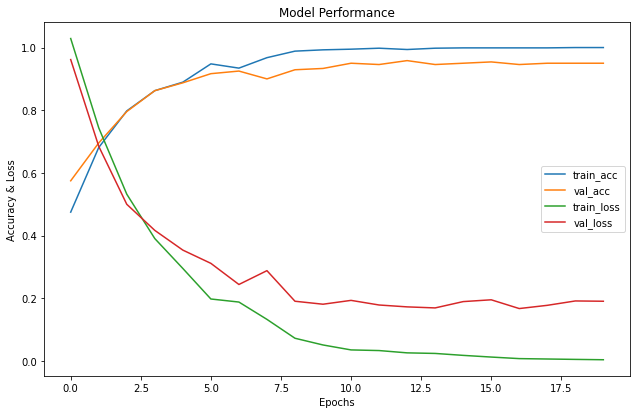

In [317]:
# epochs에 따른 accuracy, loss의 변화를 그래프로 시각화
plt.figure(figsize=(10.5, 6.5))

plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])

plt.title('Model Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy & Loss')
plt.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'], loc='center right')

## 3. 성능 평가 및 개선

### 3-1. test 데이터셋 준비

In [302]:
# test 데이터가 있는 경로를 변수에 저장
test_path = os.getenv("HOME") + "/aiffel/aiffel_projects/rock_scissor_paper/test2"

resize_images(test_path + "/rock")        # 각 이미지 크기를 112x112로 변경 후 저장
resize_images(test_path + "/scissor")
resize_images(test_path + "/paper")

(x_test, y_test) = load_data(test_path)

# test 데이터 정규화 (Min-Max Normalization)
x_test_norm = x_test / 255.0             

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
이미지 개수: 300


### 3-2. test loss, test accuracy 확인

- 최종 모델 성능: loss = 0.3777, accuracy = 0.9283

In [316]:
# loss, accuracy를 통해 model 평가
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)

38/38 - 0s - loss: 0.3777 - accuracy: 0.9283


### 3-3. 예측 확률 분포 확인
- 잘못 예측한 데이터를 랜덤으로 뽑아서 직접 확인

In [314]:
predicted_result = model.predict(x_test_norm)
predicted_labels = np.argmax(predicted_result, axis=1)

예측 확률 분포:  [1.2985501e-04 9.9952877e-01 3.4133869e-04]
라벨:  0
예측 결과:  1


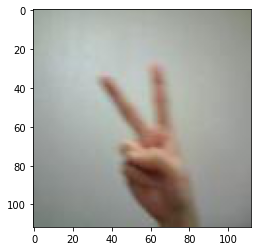

예측 확률 분포:  [9.6465677e-02 9.0283960e-01 6.9468434e-04]
라벨:  0
예측 결과:  1


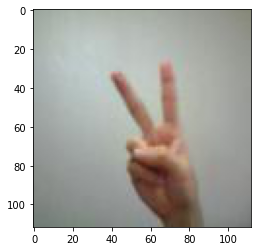

예측 확률 분포:  [2.2312073e-01 7.7621901e-01 6.6034065e-04]
라벨:  0
예측 결과:  1


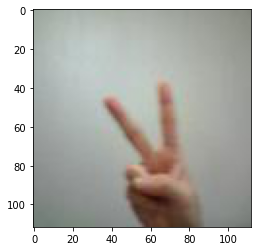

In [315]:
wrong_predict_list = []

for i, _ in enumerate(predicted_labels):
    if predicted_labels[i] != y_test[i]:         # 예측 결과와 정답이 다른 경우
        wrong_predict_list.append(i)
        
# 잘못 예측한 경우들 중 랜덤하게 3개 선정
samples = random.choices(population=wrong_predict_list, k=3)

for n in samples:
    print("예측 확률 분포: ", str(predicted_result[n]))
    print("라벨: ", str(y_test[n]))
    print("예측 결과: ", str(predicted_labels[n]))
    
    plt.imshow(x_test_norm[n], cmap=plt.cm.binary)
    plt.show()

### 3-4. 성능 개선 과정

#### 1st: train 데이터셋 추가 및 정제
- 총 train 데이터셋을 300장 -> 1200장 으로 확대
- 복잡한 배경의 이미지나 평면 상 구분이 어려운 이미지를 삭제 후 다른 이미지로 대체
- 결과적으로 accuracy 0.37 -> 0.87 로 급격히 증가


#### 2nd: 이미지 크기 조정
- 보다 정밀한 학습을 위해 28x28 -> 112x112 으로 해상도 조정

#### 3rd: 모델 하이퍼파라미터 조정
- 왼쪽 위부터 차례대로 최대 accuracy가 각각 0.9283, 0.9050, 0.9058, 0.9250로 나타남
- 가장 높은 accuracy를 보인 **첫 번째 모델**을 선택

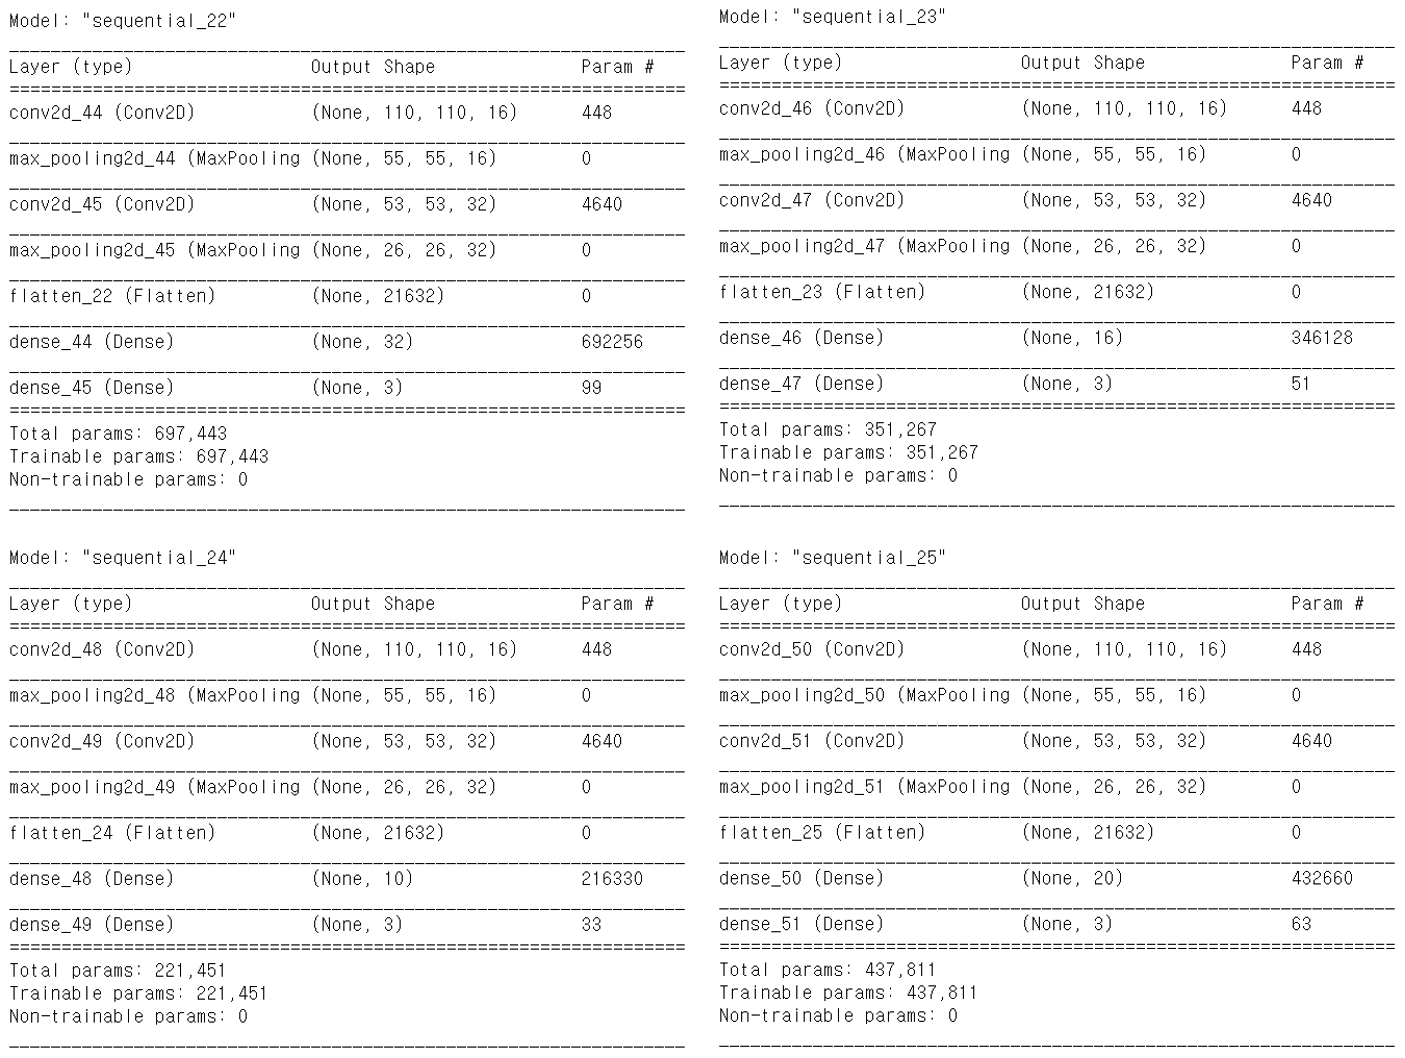

#### 4th: 오버피팅 방지 및 epochs 최적화
- train 데이터셋의 20%를 validation 데이터셋으로 활용
- validation accuracy와 loss 값, train history 그래프를 통해 오버피팅이 일어나지 않는 epochs 도출
- 결과적으로 accuracy가 0.89 -> 0.9283 로 증가

### 앞으로 더 할 것들
- 모델의 각 layer의 의미를 정확히 이해하고, 적절한 파라미터 적용
- 하이퍼파라미터를 튜닝해서 모델에 적용하고, 그 과정에서 validation 데이터셋 활용
- 모델의 성능을 판단하는 여러 지표를 이해하고 활용
- 더 나은 분류기를 만들기 위해 적절한 모델을 선택하고 적용